# Bootstrap


![Bootstrap](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/bootstrap.png)



### Lecture recap


<font color='red'>Комментарий: простые задачки для разогрева(и повторения):</font>

##### Предположим, что мы бутстрепом отобрали N событий из выборки состоящей из N наблюдений. 
  1. Какая вероятность что первый элемент бутстрепной выборки не k элемент оригинальной выборки?
  2. Какая вероятность что k элемент оригинальной выборки не входит в бутстрепную выборку?



__1.__ 
  
  $$1 - \frac{1}{N}$$
  
  
__2.__
  
  $$\left(1 - \frac{1}{N}\right)^N \sim 0.63$$
  
  
##### Обоснование использование техники ресемплирования. Эффективность и состоятельность оценки плотности вероятности функцией $\hat{F}(x) = \frac{1}{N} \sum\limits_i I[x > x_i]$.

$$E\left[ \hat{F}(x) \right] = F(x)$$


$$Var \left[ \hat{F}(x) \right] = \frac{F(x)(F(x) - 1)}{n}$$


##### Сходимость бутстрепной оценки дисперсии к аналитической на примере среднего:

$$se_{boot} = \frac{1}{B} \sum\limits_b (\hat{\mu}^*_b - \hat{\mu})^2 \rightarrow \frac{1}{N} \sum \frac{(x_i - \hat{\mu})^2}{n}$$

Доказать используя закон больших чисел.

## Пример построение CDF с помощью бутстрепа для треугольного распределения

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# CDF треугольного распределения с a = 0, b = 1, c = 2
def TrueTriangularDistrubition(x):
    if x < 0:
        return 0
    elif x < 1:
        return x**2 / 2
    elif x < 2:
        return 2*x - x**2 / 2 - 1
    else:
        return 1

In [3]:
# размер изначальной выборки
N = 300
# размер бутстрепной выборки
B = 800

X = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)
Xb = np.random.choice(X, (B, N), replace=True)
Xb.shape

(800, 300)

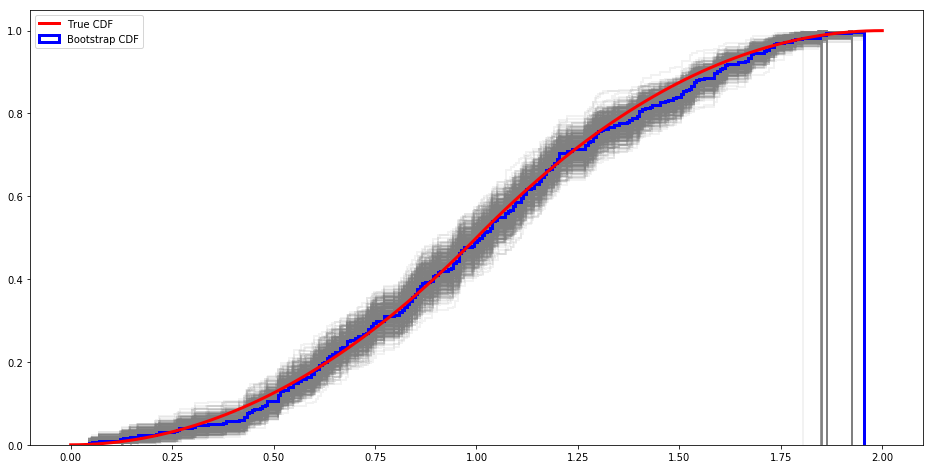

In [4]:
plt.figure(figsize = (16, 8))

# CDF для каждого бутстрепной выборки
for bootstrap_sample in Xb:
    plt.hist(bootstrap_sample, bins=N, density=True, histtype='step',
             cumulative=True, alpha = 0.1, color='grey', linewidth = 2)

# Истинное CDF
plt.plot(np.linspace(0, 2, 100), 
         list(map(TrueTriangularDistrubition, np.linspace(0, 2, 100))), 
         color = 'red', linewidth = 3, label='True CDF')    

# 
plt.hist(X, bins=N, density=True, histtype='step',
         cumulative=True, label='Bootstrap CDF', color='blue', linewidth = 3)

plt.legend()
plt.show()

### Зависимость точности приближения распределений статистик бутстрепом

Один интересный практический вопрос это как быстро сходится бутстреп. Достаточно ли 10000 испытаний, а 1000, а 100?

В целом, чем больше тем лучше, но сейчас мы увидим, что даже для оценки CDF распределения верно что $B_k$ сходится к $B_{\infty}$(значение статистики при бесконечном количестве ресемплов) как $\frac{1}{\sqrt{n}}$.

100%|██████████| 999/999 [01:12<00:00,  8.85it/s] 


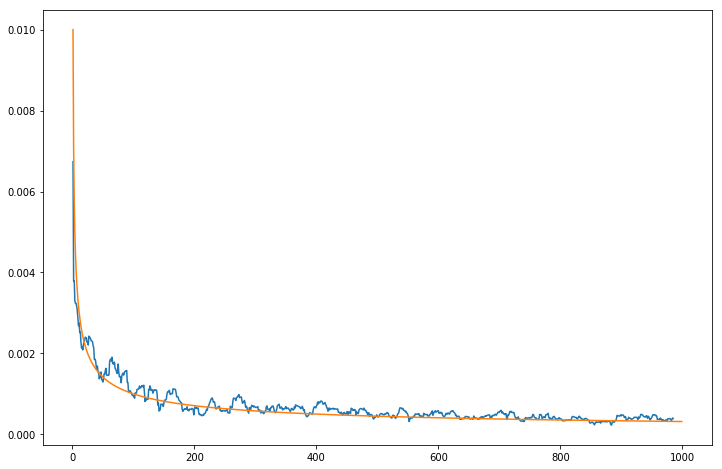

In [19]:
from tqdm import tqdm
# разбиение на бины
bins = np.linspace(0, 2, N)

# ground truth CDF
true_distr = np.array(list(map(TrueTriangularDistrubition, np.linspace(0, 2, N - 1))))

means = []

# диапазон количества испытаний для которых будем смотреть на зависимость
Bs = np.arange(1, 1000, 1)
for B in tqdm(Bs):
    # бутстрап выборки X B раз
    Xb = np.random.choice(X, (B, N), replace=True)
    cdfs = []
    for bootstrap_sample in Xb:
        # считаем разность CDF полученного бутстрапом и ground truth
        cdfs.append(
            true_distr - np.cumsum(np.histogram(bootstrap_sample, bins=bins)[0] / N)
        )
    # считаем среднее от разностей CDF
    means.append(np.array(cdfs).mean(axis=0))
    
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# считаем бегущую дисперсию, чтобы получить более гладкий график
r = np.std(rolling_window(np.array(means).mean(axis=1), 15), -1)

plt.figure(figsize=(12, 8))
plt.plot(Bs[:len(r)], r)
plt.plot(Bs, 1e-2 / np.sqrt(Bs))

На практике для оценки параметров рекомендуется использовать размер бутстрепной выборки порядка 100-1000, для интервальных оценок лучше делать >10000 испытаний.

## Сравнение t-bootstrap интервалов и обычного  бутстреп

Предположим, что у нас есть некоторая $\theta = T(X)$, то с помощью бутстрапа мы можем сгенерировать новую, бутстрапную, выборку:

$$\{ \hat{\theta}_i \}_{i=0}^{B}$$

По этой выборке можно оценивать не только стандартную ошибку, но и доверительные интервалы. Мы сравним два подхода для подсчёта доверительных интервалов. 

Перцентильный интервал интуитивно легко понять. Для оценки доверительного интервала $1 - 2 \alpha$ считается $\alpha$-квантиль и $1 - \alpha$-квантиль и объявляются верхней и нижней границами доверительного интервала, т.е.:

$$C_n = \left(\hat{\theta}^{(\alpha)}, \hat{\theta}^{(1 - \alpha)}\right)$$

Bootstrap-t оценивается по-другому:

$$C_n = \left( \hat{\theta} - \hat{t}^{(1 - \alpha)}, \hat{\theta} - \hat{t}^{(\alpha)} \right),$$

где квантили $t$ считаются от следующих оценок по бутстрапным выборкам:

$$t^*(b) = \frac{\hat{\theta}^*(b) - \hat{\theta}}{\hat{se}^*(b)}$$

In [20]:
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import expon
def mean(X):
    return np.mean(X, axis=1)

def mean_t(X, X_original):
    return (np.mean(X, axis=1) - np.mean(X_original)) / np.std(X, axis=1)

def percentile_confidence_interval(X, q=5):
    return np.percentile(X, q=q / 2), np.percentile(X, q=100 - q / 2)

In [54]:
c = cauchy()

'cauchy'

In [66]:
def plot_statistics(distr, limits_1, limits_2, limits_3, mean_val):
    X = distr.rvs(size=N)
    boots = np.random.choice(X, (B, N), replace=True)
    mean_boots = mean(boots)
    mean_boots_t = mean_t(boots, X)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle('{} distribution. N={}, B={}'.format(distr.dist.name, N, B))
    axes[0].hist(X, bins=100, density=True, range=limits_1);
    axes[0].axvline(x=mean_val, linewidth=4, color='r')
    axes[0].set_xlim(limits_1)
    # axes[0].legend()
    axes[1].hist(mean_boots, bins=100, density=True, range=limits_2);
    # axes[1].axvline(x=mean_val, linewidth=4, color='r')
    lower_interval, higher_interval = percentile_confidence_interval(mean_boots)
    axes[1].axvline(x=lower_interval, linewidth=1, 
                    color='r', linestyle='--')
    axes[1].axvline(x=higher_interval, linewidth=1, 
                    color='r', linestyle='--', label='Percentile bootstrap interval')
    lower_interval, higher_interval = percentile_confidence_interval(mean_boots_t)

    axes[1].axvline(x=X.mean() - X.std() * higher_interval, linewidth=1, 
                    color='g', linestyle='-')
    axes[1].axvline(x=X.mean() - X.std() * lower_interval, linewidth=1, 
                    color='g', linestyle='-', label='t-bootstrap interval')
    axes[1].set_xlim(limits_2)
    axes[1].legend()
    
    axes[2].hist(mean_boots_t, bins=100, density=True, range=limits_3);
    # axes[2].axvline(x=0, linewidth=4, color='r')
    lower_interval, higher_interval = percentile_confidence_interval(mean_boots_t)
    axes[2].axvline(x=lower_interval, linewidth=1,
                    color='r', linestyle='--')
    axes[2].axvline(x=higher_interval, linewidth=1, 
                    color='r', linestyle='--', label='t-bootstrap interval')
    axes[2].set_xlim(limits_3)
    axes[2].legend()
    plt.show()

In [67]:
N = 15
B = 5000

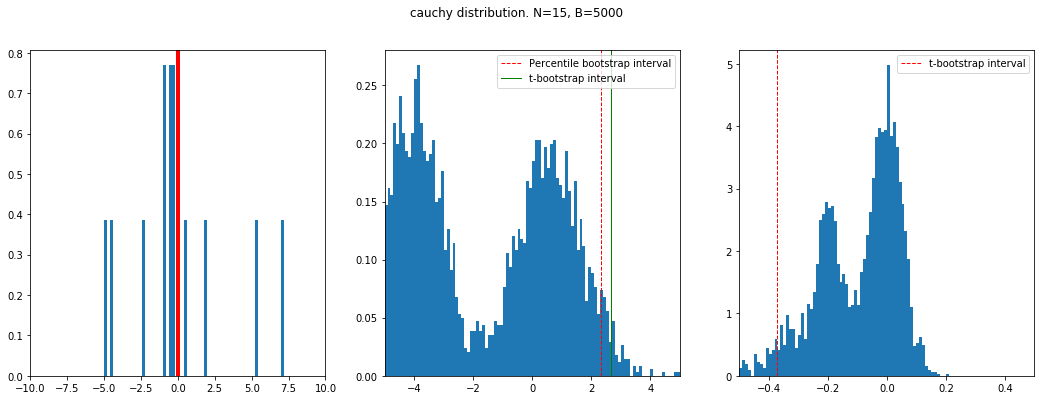

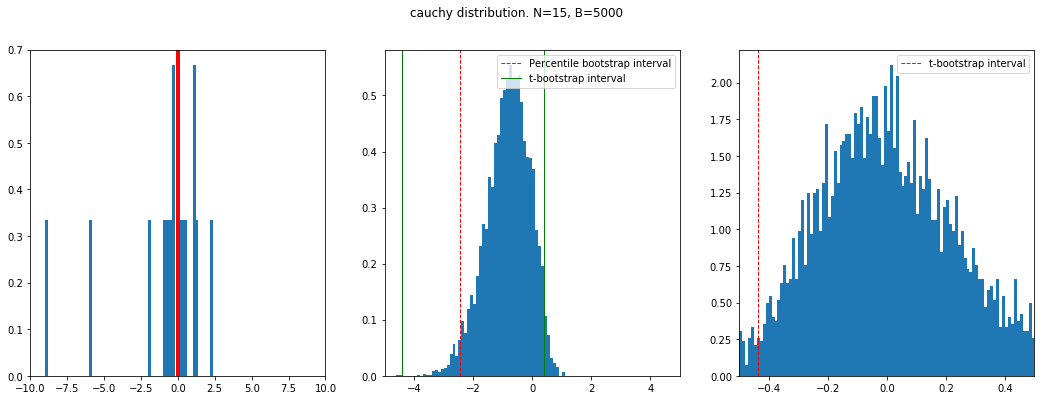

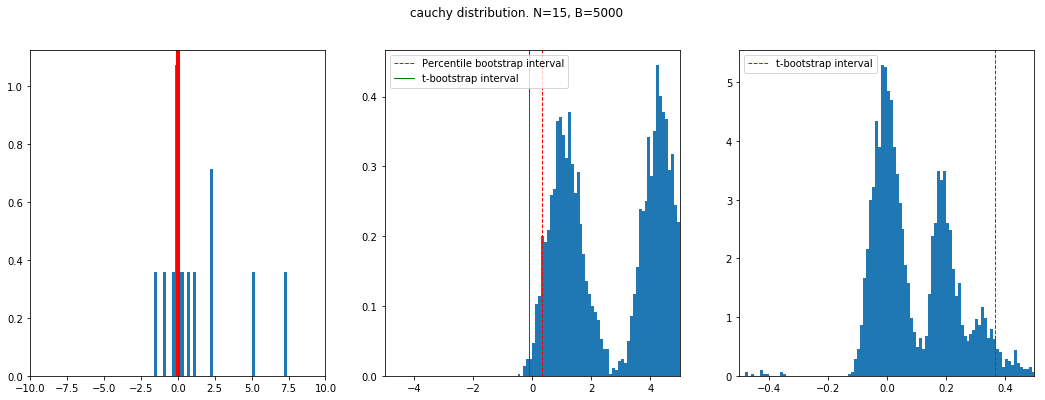

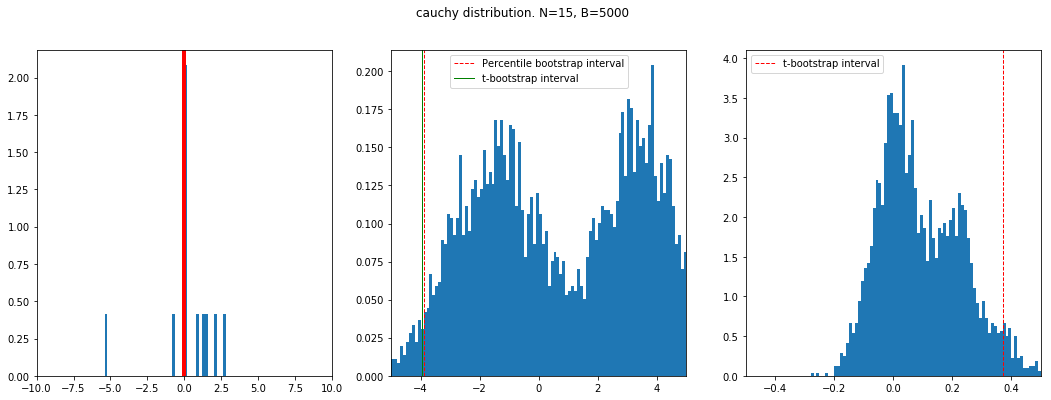

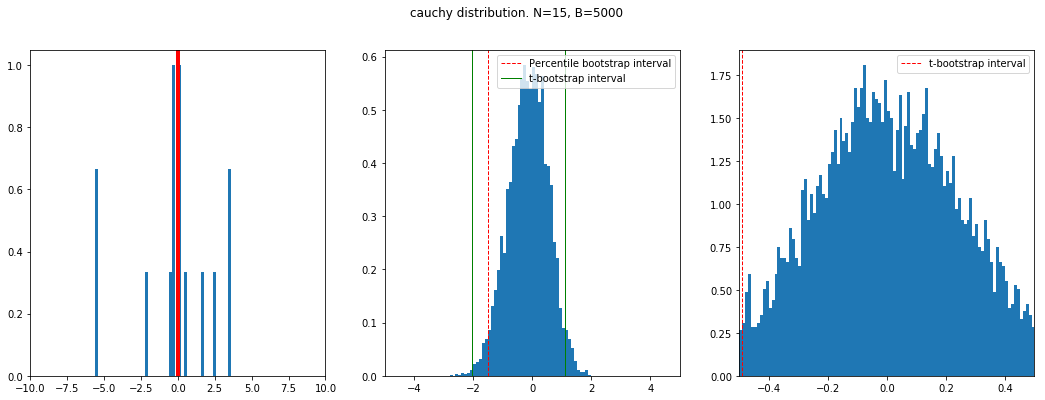

In [68]:
for i in range(5):
    plot_statistics(cauchy(), [-10, 10], [-5, 5], [-0.5, 0.5], 0)

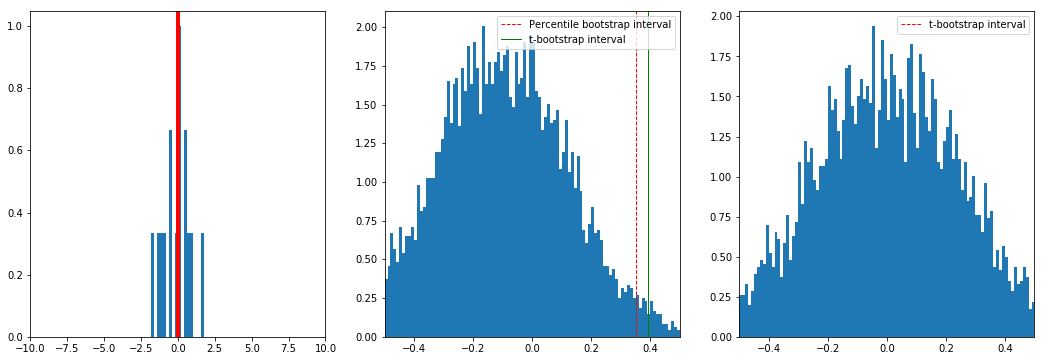

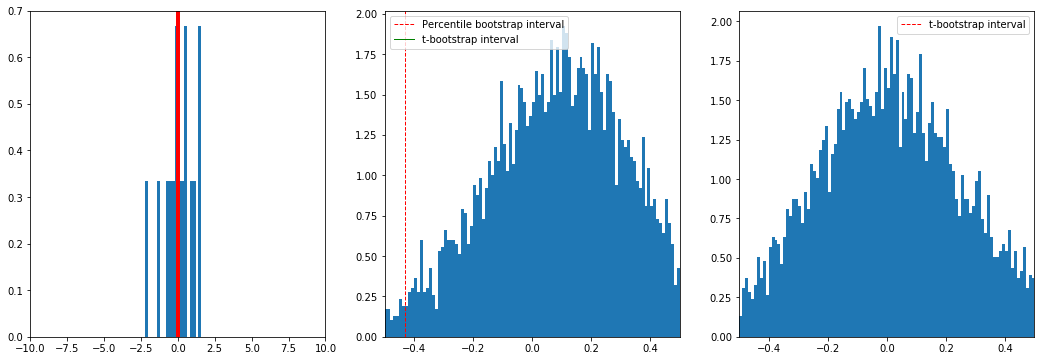

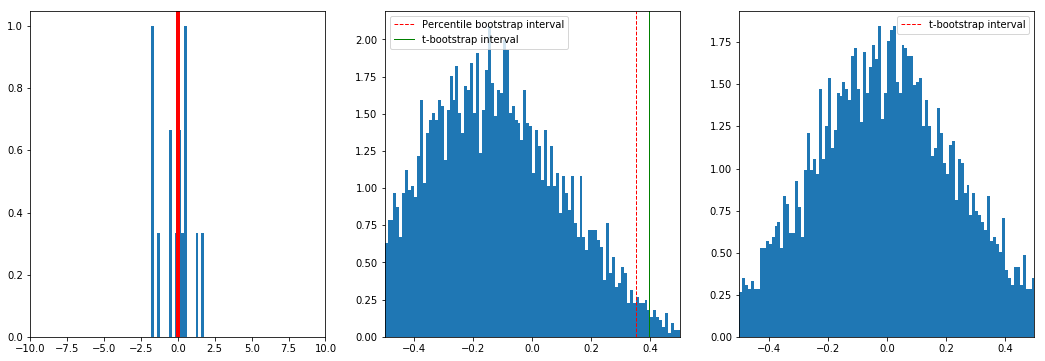

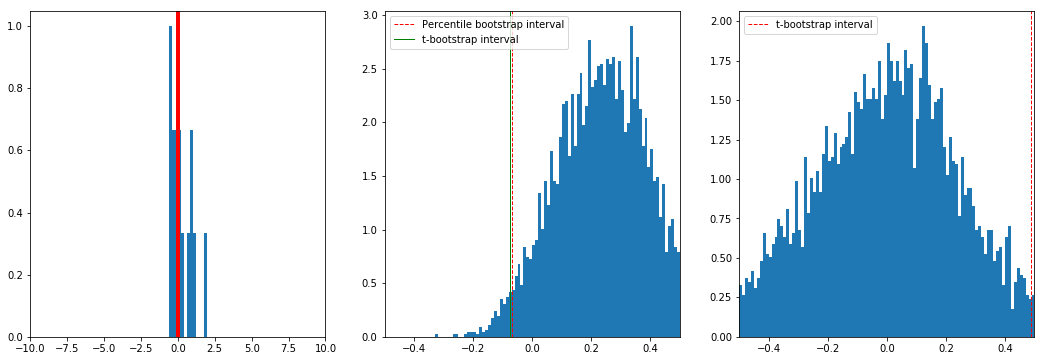

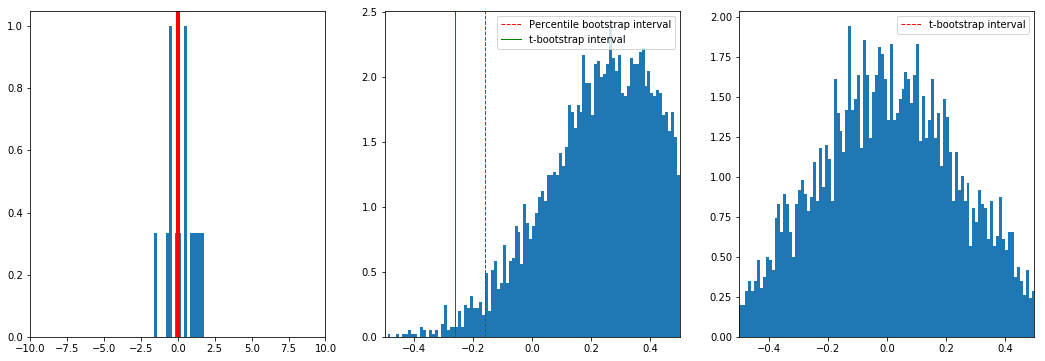

In [51]:
for i in range(5):
    plot_statistics(norm(), [-10, 10], [-0.5, 0.5], [-0.5, 0.5], 0)

In [52]:
#for i in range(5):
#    plot_statistics(t(3), [-10, 10], [-3, 3], [-1, 1], 0)

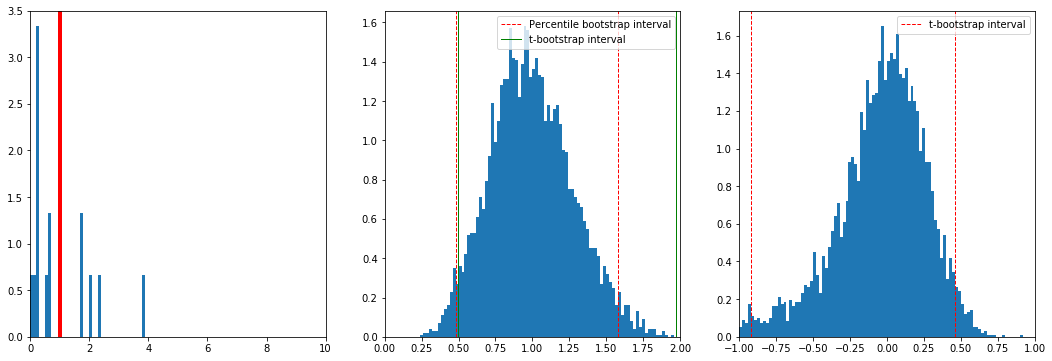

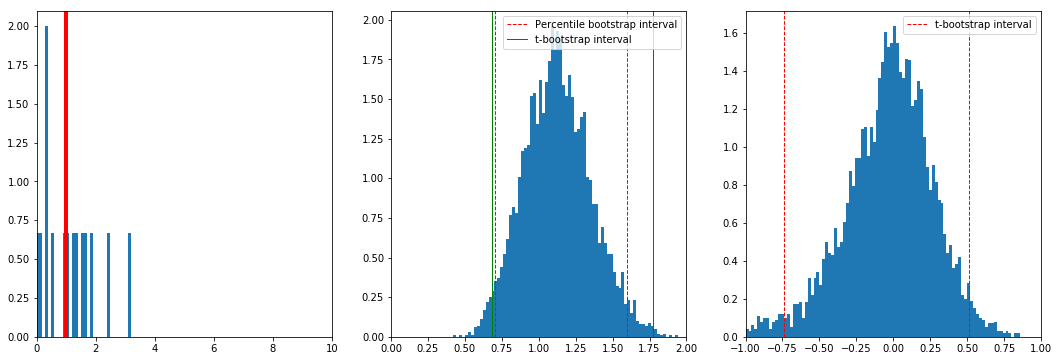

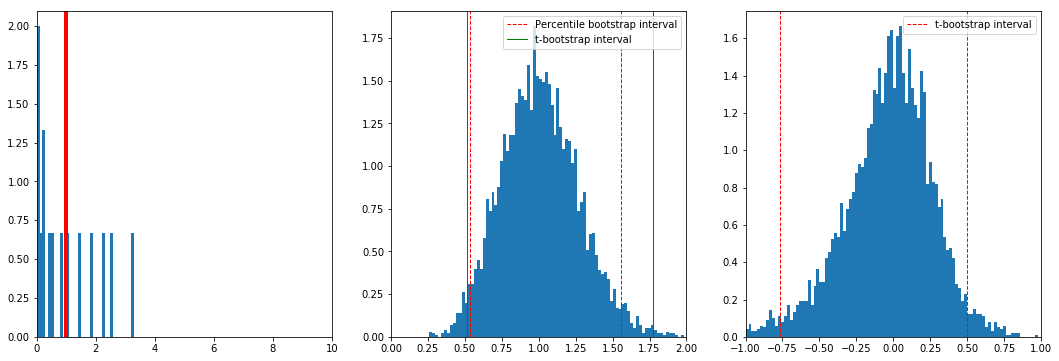

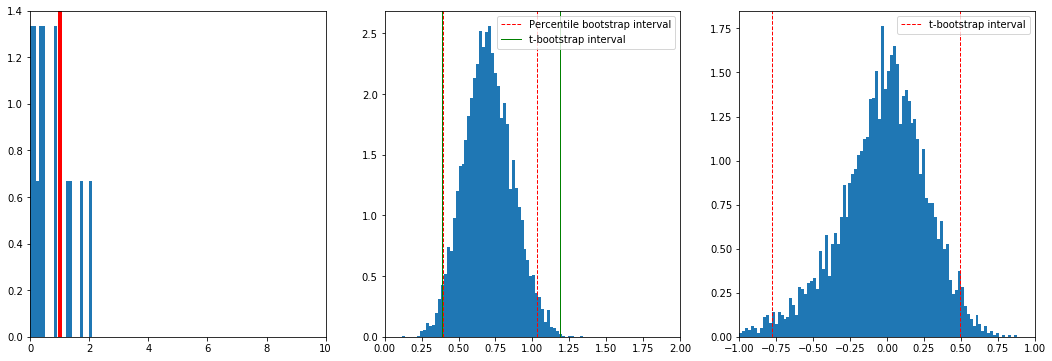

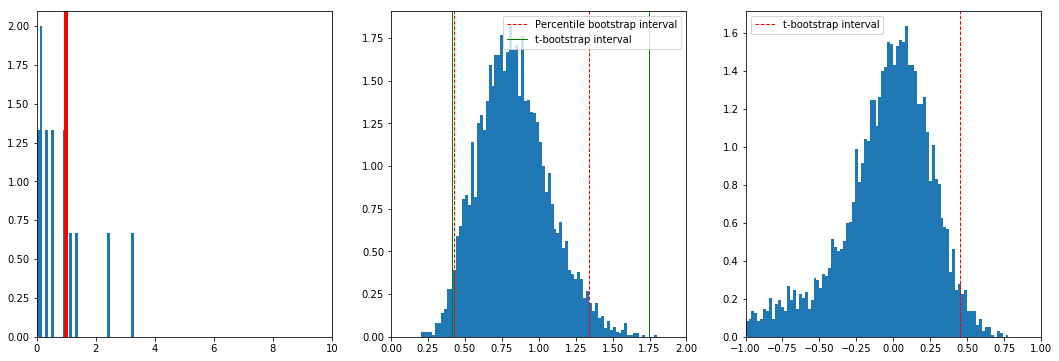

In [53]:
for i in range(5):
    plot_statistics(expon(), [0, 10], [1. - 1, 1. + 1], [-1, 1], 1)

## Вывод

В целом, перцентильный интервал выглядит самым простым вариантом оценивания, однако в реальности он даёт весьма плохие результаты так как __сильно__ зависит от того насколько хорошо изначальная выборка аппроксимирует истинное распределение случайной величины. Часто можно встретить советы что лучше __не используйте__ перцентильный бутстрап для оценки доверительных интервалов, однако, конечно, самое правильное решение это тестировать все доступные методы.

У t-bootstrap есть одно интересное свойство, к примеру,: как можно было заметить на последнем примере с экспоненциальным распределением, интервалы t-bootstrap смещены влево. t-bootstrap "уважает" ассиметрию распределений при расчёте доверительных интервалов.

## Интегрирование с помощью бутстрепа

Интегрирование функции $$f(x) = x \cos (71 x) + \frac{\sin (13 x^2)}{x}$$ на интервале $(0, 1)$.

In [ ]:
def f(x):
    return x * np.cos(71 * x) + np.sin(13 * x**2) / x

x = np.linspace(0, 1, 100)

plt.plot(x, f(x))

In [ ]:
# data sample for integration
n = 100
x = f(np.random.random(n))

# bootstrap MC integration
reps = 1000
xb = np.random.choice(x, (n, reps), replace=True)
yb = 1 / np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)


plt.figure(figsize = (16, 8))
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.1)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=2)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b', linewidth=2, label='95% interval');
plt.axvline(21, 0, 1)
plt.axvline(100, 0, 1)
plt.axhline(0.762816332183, c='c', label='True integral value')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (16, 8))
plt.hist(yb[20, :], 25, histtype='step', normed=True, linewidth=2)
plt.hist(yb[99, :], 25, histtype='step', normed=True, linewidth=2)
plt.show()

## Bootstrap bias estimatiom для двух проблем


$$B \sim \frac{e^N}{\sqrt{N}}$$

Посмотрим как можно оценивать смещение оценки с помощью бутстрепа и jacknife на трёх примерах:

<font color='red'>Комментарий: если останется время, то MLE оценки можно вывести</font>

  * $x_i \sim Exp(1)$, $\theta = \sigma^2$, $\hat{\theta} = \frac{1}{N} \sum (x_i - \bar{x})^2$ -- смещённая оценка дисперсии. $\hat{\theta} = \frac{1}{N - 1} \sum (x_i - \bar{x})^2$ -- несмещённая оценка.
  * $x_i \sim U(0, \theta)$, $\hat{\theta} = \max(x_i)$ -- смещённая оценка максимума равномерного распределения. $\hat{\theta} = \frac{N + 1}{N}\max(x_i)$ -- несмещённая оценка.
  * $x_i \sim U\{0, \theta\}, \theta \in N$, $\hat{\theta} = \max(x_i)$ -- смещённая оценка максимума равномерного дискретного распределения. $\hat{\theta} = \frac{N + 1}{N} \max(x_i) - 1$  -- несмещённая оценка.
  
  Зачем нужно уметь оценивать максимум дискретного распределения? Чтобы увидев на танке противника №60 дать состоятельную и несмещённую оценку общего числа танков ;)
  
  ![](https://upload.wikimedia.org/wikipedia/commons/6/61/Bundesarchiv_Bild_183-H26258%2C_Panzer_V_%22Panther%22.jpg)
  
  https://en.wikipedia.org/wiki/German_tank_problem

#### Bootstrap bias & jacknife bias

Для оценки смещения будем использовать обычный бутстреп и jacknife.

Для бутстрепа смещение считается следующим образом:

$$\hat{bias}_B = \hat{\theta}^* - \hat{\theta}$$

Для jacknife:

$$\hat{bias}_{jack} = (n - 1) ( \hat{\theta}_{(\cdot)} - \hat{\theta})$$


#### Коррекция

В общем случае коррекция делается следующим образом:

$$\bar{\theta} = \hat{\theta} - \hat{bias}$$

Однако следует осознанно делать коррекцию, так как оценка смещения может иметь большую ошибку и тогда уменьшение смещения оценки будет __нивелировано__ возросшей дисперсией.

https://arxiv.org/pdf/1709.06183.pdf

In [ ]:
def jackknife_resampling(data):
    n = data.shape[0]
    resamples = np.empty([n, n-1])
    for i in range(n):
        resamples[i] = np.delete(data, i)
    return resamples


def jackknife_stats(data, statistic):
    from scipy.special import erfinv
    n = data.shape[0]
    resamples = jackknife_resampling(data)

    stat_data = statistic(data)
    jack_stat = np.apply_along_axis(statistic, 1, resamples)
    mean_jack_stat = np.mean(jack_stat, axis=0)

    bias = (n - 1) * (mean_jack_stat - stat_data)

    estimate = stat_data - bias

    return stat_data, bias, estimate

def bootstrap_stats(X, statistic, B=1000):
    boots = np.random.choice(X, (B, N), replace=True)
    stat_data = np.mean(statistic(boots, axis=1))
    bias = stat_data - statistic(X)
    
    estimate = statistic(X) - bias

    return stat_data, bias, estimate

### Оценка $\sigma^2$ для $expo$

In [ ]:
def plot_bias_comparison_sigma(N=10):
    X = expon().rvs(N)
    
    true_bias = np.std(X) - np.std(X, ddof=1)
    _, jack_bias, _ = jackknife_stats(X, statistic=np.std)

    Bs = np.logspace(1, 3, 20).astype(int)
    boot_biases = []
    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=np.std, B=B)
        boot_biases.append(boot_bias)
        
    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

In [ ]:
plot_bias_comparison_sigma(N=1000)

In [ ]:
from scipy.stats import kurtosis
def plot_bias_comparison_kurtosis(N=10):
    X = expon().rvs(N)
    
    true_bias = kurtosis(X) - kurtosis(X, bias=False)
    _, jack_bias, _ = jackknife_stats(X, statistic=kurtosis)

    Bs = np.logspace(1, 3, 20).astype(int)
    boot_biases = []
    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=kurtosis, B=B)
        boot_biases.append(boot_bias)
        
    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

In [ ]:
plot_bias_comparison_kurtosis(N=2000)

### Оценка $\theta$ для $U[0, \theta]$ и для $U\{0, \theta\}$

In [ ]:
def plot_bias_comparison_sigma_uniform(N=10):
    X = np.random.uniform(0, 1, N)
    
    true_bias = np.max(X) - np.max(X) * (len(X) + 1) / len(X)

    _, jack_bias, _ = jackknife_stats(X, statistic=np.max)
    boot_biases = []

    Bs = np.logspace(1, 4, 20).astype(int)

    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=np.max, B=B)
        boot_biases.append(boot_bias)
        
    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

def plot_bias_comparison_sigma_discrete(N=10, theta=100):
    X = np.random.choice(np.arange(0, int(theta)), size=N, replace=True)
    # X = np.random.choice(np.arange(0, int(theta)), size=N, replace=False)
    true_bias = np.max(X) - (np.max(X) * (len(X) + 1) / len(X))

    _, jack_bias, _ = jackknife_stats(X, statistic=np.max)
    boot_biases = []

    Bs = np.logspace(1, 4, 20).astype(int)

    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=np.max, B=B)
        boot_biases.append(boot_bias)

    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

In [ ]:
# запустите несколько раз
plot_bias_comparison_sigma_uniform(N=100)

In [ ]:
# запустите несколько раз
plot_bias_comparison_sigma_discrete(N=1000, theta=1500)

#### Общее наблюдение

Оценка смещения jacknife имеет более высокий порядок точности($o\left(\frac{1}{N^2}\right)$) чем бутстрепная оценка($o\left(\frac{1}{N}\right)$), что можно увидеть на примере оценки дисперсии и куртозис, поэтому имеет смысл в большинстве случаев использовать jacknife для оценки смещения.

Однако, jacknife "ломается" на негладких статистиках: медиана, максимум, к примеру. В этом случае лучше использовать обычный bootstrap.

? resampling

## Бутстреп временных рядов


Бутстреп временных рядов обычно делают в два шага:

  1. Обучают модель для предсказания временного ряда(авторегрессия, к примеру).
  $$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2}$$
  2. Запоминают остатки(residuals) от истинных значений и предсказанных:
  $$\hat{\epsilon} = y_t - (\beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2})$$
  3. Новые данные сэмплируют применяя обученную модель и добавляя к предсказанию случайно выбранное значение из residuals:
  $$\hat{y_t} = \beta_0 + \beta_1 \hat{y}_{t-1} + \beta_2 \hat{y}_{t-2} + (\epsilon \sim \hat{\epsilon}) $$

In [297]:
from tslearn.datasets import UCR_UEA_datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import linear_model
clf = linear_model.RANSACRegressor()

In [423]:
def make_regression_from_time_series(X, n):
    """
    X: 1D-numpy массив временных данных
    n: количество сэмплов для предсказания
    return: X, Y = [x_{t-n}, x_{t-n+1}, ..., x_{t-1}], x_{t}
    """
    N = len(X)
    x = np.zeros((N-n, n))
    y = np.zeros((N-n, 1))

    for i in range(N-n):
        x[i,:] = X[i: i+n]
        y[i] = X[i+n]

    return x,y

n = 3

In [436]:
Lightning2=UCR_UEA_datasets().load_dataset('Lightning2')

# создаём обучающую выборку
X_list, Y_list = [], []
for dataset in Lightning2[0]:
    X_tmp, Y_tmp = make_regression_from_time_series(dataset.ravel(), 5)
    X_list.append(X_tmp)
    Y_list.append(Y_tmp)
X=np.concatenate(X_list)
Y=np.concatenate(Y_list)
clf.fit(X, Y)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_metric=None,
        residual_threshold=None, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [437]:
# остатки = предсказания модели - реальные данные
residuals = clf.predict(X).ravel() - Y.ravel()

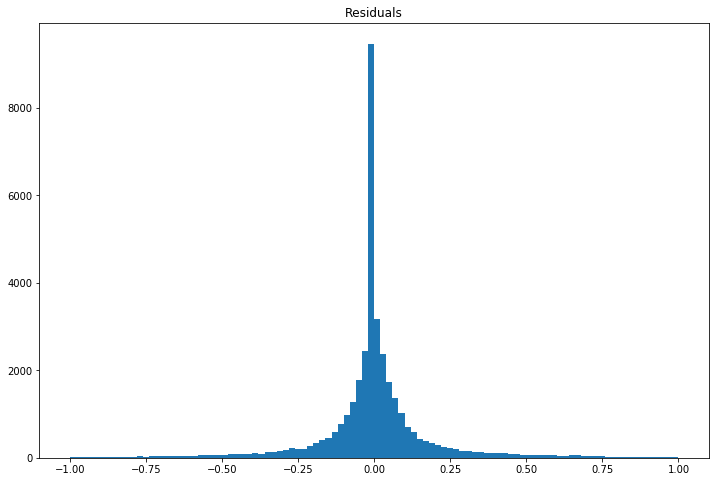

In [438]:
# мы хотим чтобы остатки были распределены по нормальному закону около нуля
# это является индикатором что ошибки случайны и не коррелируют
plt.figure(figsize=(12, 8))
plt.title('Residuals')
plt.hist(residuals, bins=100, range=(-1, 1));
plt.show()

In [439]:
def bootstrap_timeseries(clf, xinit, residuals, N):
    n = len(xinit)
    bootstrap_sample = []
    current_sample = xinit
    for i in range(N):
        new_dot = clf.predict([current_sample]).ravel()[0] + np.random.choice(residuals)
        bootstrap_sample.append(new_dot)
        current_sample = np.roll(current_sample, -1)
        current_sample[-1] = new_dot
    return bootstrap_sample

In [442]:
bootstraped_timeseries = bootstrap_timeseries(clf, X[0, :] - X.mean(axis=0), residuals, 1000)

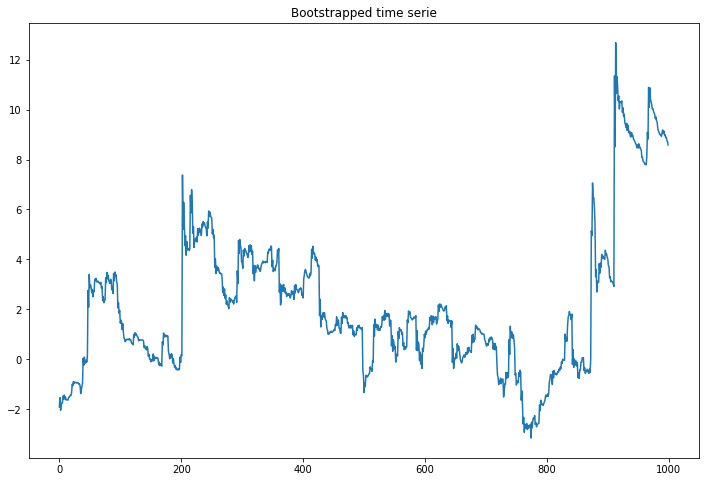

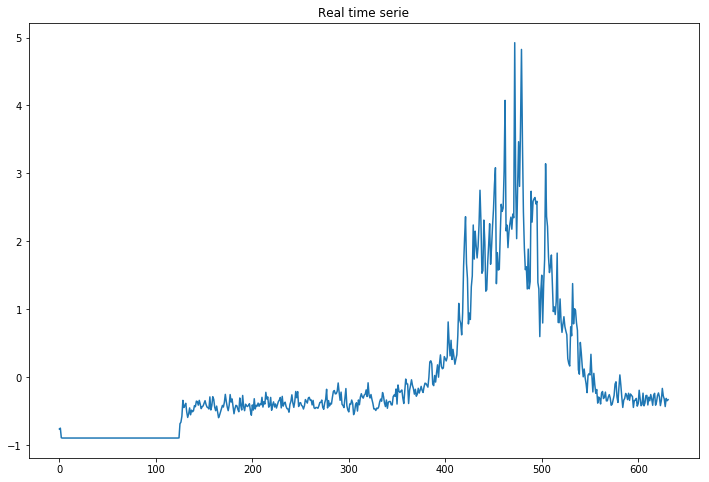

In [443]:
plt.figure(figsize=(12, 8))
plt.title('Bootstrapped time serie')
plt.plot(bootstraped_timeseries)
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Real time serie')
plt.plot(Y_list[0])
plt.show()

In [ ]:
|